# Dataset Selection and Preliminary Research
- Select a dataset of interest from a public data repository.
- Conduct preliminary research to understand the dataset’s context and potenDal
quesDons to explore.

In [ ]:
# Libraries which i will Utilize
from scipy.stats import chisquare, chi2_contingency, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests

## Calling the Data

For my Data Set I Created an API on my Company's Server (with their Permission)
to Analyse, Clean and Visualize the Data.

This Data is something I have Structured Tables for & worked with over the Few Years
My Goal is to Analyse the Data and hopefully provide some Useful Insights for the Company.

In [491]:
# API Connection to get the data & Create a DataFrame
rest_api = True # Boolean for in case i change the Structure of the API on System side.
domain = "https://smooth-ocean.tech/" # Domain of the API
app = "gmac-operations/" # Application Name
extension = "seneca_jcp_mss/api/" # Extension of the API
url = domain + app + extension # URL of the API

# Data to be sent to the API
data = {
    "auth": "SenecaPC_jcpattasseril_AIG_xxx"
}

if rest_api: # Data to be sent to the API in case of POST request
    """
    We can add more parameters to the data to get more specific data
    For Example, we can add the country name to get the data of a specific country
    We can also add the flag_history to get the history of the data
    """
    data.update({
        "country": [
            "SAUDI ARABIA",
            # "KUWAIT",
        ], #Country Name currently only have access to these two countries data & can use this as a filter to get the data of a specific country
        # "flag_history": True # To get Histroy or Current Data of the Container Inventory, NOTE: Don't Provide this parameter if you want ALL the data
    })

response = requests.post(url, json=data) if rest_api else requests.post(url, headers=data) 

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
else:
    df = pd.DataFrame()
# # df.to_csv("Seneca_Containers.csv", index=False)
# df # Uncomment to see the whole DataFrame but i dont advise it as it is very large

## Understanding the Data

In [492]:
df.shape # Getting the Shape of the DataFrame in (Rows, Columns) format

(8672, 52)

In [493]:
df.columns # Gets the Columns of the DataFrame

Index(['id', 'CLIENT_NAME', 'PRINCIPAL_NAMES', 'LOCATION_NAME', 'BOOKING_NO',
       'CONTAINER_SIZE', 'DESTINATION_AGENT', 'DISCHARGE_STATUS',
       'LOADING_STATUS', 'DISCHARGE_DATE', 'DISCHARGE_AT_ICD', 'DO_DATE',
       'SAILING_DATE', 'IMPORT_BL_NUMBER', 'IMP_POL', 'IMP_POD', 'IMP_FPOD',
       'FREE_DAYS_IMPORT', 'IMPORT_FULL_DAYS', 'EMPTY_FULL',
       'EMPTY_IDLING_DAYS', 'SNTC_DATE', 'SNTS_DATE', 'RCVC_DATE', 'RCVS_DATE',
       'RAILED_IN', 'RAILED_OUT', 'EXPORT_BL_NUMBER', 'EXP_POL', 'EXP_POD',
       'EXP_FPOD', 'FREE_DAYS_EXPORT', 'SRR_NO', 'DM_AV_UR', 'SOC', 'ISO_Code',
       'GRADE', 'TERMINAL', 'DROPPED', 'REMARKS', 'SLOT_OPERATOR_IMPORT',
       'SLOT_OPERATOR_EXPORT', 'DEPOT_NAME', 'DEPOT_FREE_TIME', 'flag_history',
       'added_by', 'session_id', 'added_on', 'CONTAINER_NUMBER',
       'CONTAINER_TYPE', 'IMP_VESSEL_VOY', 'EXP_VESSEL_VOY'],
      dtype='object')

In [494]:
df = df.filter([
    'CLIENT_NAME', 'PRINCIPAL_NAMES', 'LOCATION_NAME',
    'CONTAINER_NUMBER', 'CONTAINER_TYPE', 'CONTAINER_SIZE',
    'DISCHARGE_DATE', 'IMPORT_BL_NUMBER', 'IMP_POL', 'IMP_POD', 'IMP_FPOD', 'IMP_VESSEL_VOY',
    'SAILING_DATE', 'EXPORT_BL_NUMBER', 'EXP_POL', 'EXP_POD', 'EXP_FPOD', 'EXP_VESSEL_VOY',
    'DO_DATE', 'SNTC_DATE', 'SNTS_DATE', 'RCVC_DATE', 'RCVS_DATE',
    'REMARKS', 'flag_history',
    'added_by', 'added_on', 'session_id'
], axis=1) # Im Filtering the Columns to get only the required Columns which we need to work on as the DataFrame is very large and has alot of Columns we dont need

# Creating a Function to get the Columns with Null Values
def get_null_col_count(df):
    for col, idx in df.isnull().sum().items():
        if idx > 0:
            print(col, idx)

# Getting ALL the Columns with Null Values
df.isnull().sum().items() # get_null_col_count(df)

In [ ]:
## Questions we are Going to Explore:
"""
1. Monthly Demand to & from a Country to Other Countries?
2. What is the Monthly Distribution of the Containers in the Inventory?
"""

'\n'

# Data Cleaning and Preprocessing
- Use Pandas (or anything else you wish) to clean the dataset, handling missing
values, outliers, and incorrect data types.
- Perform necessary data transformaDons to prepare the dataset for analysis.

## What must be Cleaned
> As Understood from Above the Data has ALOT of Null Values which needs to be cleaned.
<br>For Our Goals we must Clean the Data and Remove the Columns which are not Required.

In [496]:
axis = 0 # Used for Later as a parameter in Deciding how im gonna clean the Data

For the First Layer of Cleaning i will Clean Up the Important Date Values in the Data Frame
These are (in order):
1. Discharge Date (Date it **Arrives** at Location)
2. DO Date (DO - `Delivery Order`)
3. SNTC Date (`SNTC` - **Sent for Container**)
4. SNTS Date (`SNTS` - **Sent for Store**)
5. RCVC Date (`RCVC` - **Received Container**)
6. RCVS Date (`RCVS` - **Received Store**)
7. Sailing Date  (Date it **Leaves** a Location)

In [497]:
# First im Taking all the Columns in the Order of the Dates from First Arriving to Last when it Leaves
fillerDf = df[['DISCHARGE_DATE','DO_DATE', 'SNTC_DATE', 'SNTS_DATE', 'RCVC_DATE', 'RCVS_DATE','SAILING_DATE']]
fillerDf # NOTE: Our Final Goal is to make Sure DISCHARGE_DATE & SAILING_DATE is not Null

,DISCHARGE_DATE,DO_DATE,SNTC_DATE,SNTS_DATE,RCVC_DATE,RCVS_DATE,SAILING_DATE
0,2024-04-03,2025-02-03,2025-02-04,2025-02-06,2025-02-05,2024-09-22,None
1,2024-04-03,2024-04-06,2025-02-04,2025-02-06,2025-02-05,2024-09-22,None
2,2024-05-03,2024-05-09,2024-05-13,2025-02-05,2024-05-13,2025-02-06,None
3,2024-05-03,2024-05-29,2024-06-04,2024-09-24,2024-06-04,2024-09-21,None
4,2024-02-08,2024-02-11,2024-02-14,None,2024-02-14,2024-09-23,None
...,...,...,...,...,...,...,...
8667,2024-10-23,None,None,None,2024-10-28,None,2024-10-28
8668,2024-10-23,None,None,None,2024-10-28,None,2024-10-28
8669,2024-10-23,None,None,None,2024-10-31,None,2024-10-31
8670,2024-04-08,None,None,None,None,None,2024-05-23


In [498]:
# If a User Explores the Data he will Notice there are some Dates in Year 1690 which is a Flag Value in the Database so im gonna Nullify those Dates
def check_and_nullify_date(date):
    if date is not None and len(date) >= 4:
        year = int(date[:4])
        if year < 1691: # 1690 is a Flag Value in Database.
            # print(date)
            return None
    return date
fillerDf = fillerDf.applymap(check_and_nullify_date)
fillerDf

C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_18360\2994568682.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fillerDf = fillerDf.applymap(check_and_nullify_date)


,DISCHARGE_DATE,DO_DATE,SNTC_DATE,SNTS_DATE,RCVC_DATE,RCVS_DATE,SAILING_DATE
0,2024-04-03,2025-02-03,2025-02-04,2025-02-06,2025-02-05,2024-09-22,None
1,2024-04-03,2024-04-06,2025-02-04,2025-02-06,2025-02-05,2024-09-22,None
2,2024-05-03,2024-05-09,2024-05-13,2025-02-05,2024-05-13,2025-02-06,None
3,2024-05-03,2024-05-29,2024-06-04,2024-09-24,2024-06-04,2024-09-21,None
4,2024-02-08,2024-02-11,2024-02-14,None,2024-02-14,2024-09-23,None
...,...,...,...,...,...,...,...
8667,2024-10-23,None,None,None,2024-10-28,None,2024-10-28
8668,2024-10-23,None,None,None,2024-10-28,None,2024-10-28
8669,2024-10-23,None,None,None,2024-10-31,None,2024-10-31
8670,2024-04-08,None,None,None,None,None,2024-05-23


In [499]:
# Transposing the DataFrame
fillerDf = fillerDf.T if axis == 0 else fillerDf
fillerDf

,0,1,2,3,4,5,6,7,8,9,...,8662,8663,8664,8665,8666,8667,8668,8669,8670,8671
DISCHARGE_DATE,2024-04-03,2024-04-03,2024-05-03,2024-05-03,2024-02-08,2024-06-21,2024-05-03,2024-06-21,2024-05-03,2024-05-03,...,2024-09-24,2024-10-01,2024-10-01,2024-10-01,2024-10-01,2024-10-23,2024-10-23,2024-10-23,2024-04-08,2024-09-08
DO_DATE,2025-02-03,2024-04-06,2024-05-09,2024-05-29,2024-02-11,2024-07-08,2025-02-03,2024-06-27,2024-05-15,None,...,None,None,None,None,None,None,None,None,None,None
SNTC_DATE,2025-02-04,2025-02-04,2024-05-13,2024-06-04,2024-02-14,2024-07-09,2024-05-07,2024-06-27,2024-05-20,None,...,None,None,None,None,None,None,None,None,None,None
SNTS_DATE,2025-02-06,2025-02-06,2025-02-05,2024-09-24,None,2024-09-22,None,2024-09-22,2024-09-22,None,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,None,None,None,None,2024-12-10
RCVC_DATE,2025-02-05,2025-02-05,2024-05-13,2024-06-04,2024-02-14,2024-07-09,2024-05-07,2024-06-27,2024-05-20,None,...,2024-10-03,2024-10-07,2024-10-06,2024-10-08,2024-10-08,2024-10-28,2024-10-28,2024-10-31,None,None
RCVS_DATE,2024-09-22,2024-09-22,2025-02-06,2024-09-21,2024-09-23,2024-09-22,2024-09-21,2024-09-22,2024-09-22,None,...,None,None,None,None,None,None,None,None,None,2024-12-02
SAILING_DATE,None,None,None,None,None,None,None,None,None,None,...,2024-11-02,2024-12-17,2024-11-11,2024-11-04,2024-11-04,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-09-06


In [500]:
# Filling the Dates with the Previous Dates as the Dates are in Order of Arrival to Exit
fillerDf = fillerDf.fillna(
    method='bfill',
    axis=axis
) # backwards-fill to fill Discharge Date
fillerDf

C:\Users\JonathanChackoPattas\AppData\Local\Temp\ipykernel_18360\292588285.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fillerDf = fillerDf.fillna(


,0,1,2,3,4,5,6,7,8,9,...,8662,8663,8664,8665,8666,8667,8668,8669,8670,8671
DISCHARGE_DATE,2024-04-03,2024-04-03,2024-05-03,2024-05-03,2024-02-08,2024-06-21,2024-05-03,2024-06-21,2024-05-03,2024-05-03,...,2024-09-24,2024-10-01,2024-10-01,2024-10-01,2024-10-01,2024-10-23,2024-10-23,2024-10-23,2024-04-08,2024-09-08
DO_DATE,2025-02-03,2024-04-06,2024-05-09,2024-05-29,2024-02-11,2024-07-08,2025-02-03,2024-06-27,2024-05-15,None,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-10
SNTC_DATE,2025-02-04,2025-02-04,2024-05-13,2024-06-04,2024-02-14,2024-07-09,2024-05-07,2024-06-27,2024-05-20,None,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-10
SNTS_DATE,2025-02-06,2025-02-06,2025-02-05,2024-09-24,2024-02-14,2024-09-22,2024-05-07,2024-09-22,2024-09-22,None,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-10
RCVC_DATE,2025-02-05,2025-02-05,2024-05-13,2024-06-04,2024-02-14,2024-07-09,2024-05-07,2024-06-27,2024-05-20,None,...,2024-10-03,2024-10-07,2024-10-06,2024-10-08,2024-10-08,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-02
RCVS_DATE,2024-09-22,2024-09-22,2025-02-06,2024-09-21,2024-09-23,2024-09-22,2024-09-21,2024-09-22,2024-09-22,None,...,2024-11-02,2024-12-17,2024-11-11,2024-11-04,2024-11-04,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-02
SAILING_DATE,None,None,None,None,None,None,None,None,None,None,...,2024-11-02,2024-12-17,2024-11-11,2024-11-04,2024-11-04,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-09-06


In [501]:
# We can work on the Assumption that if the Forward Values are Empty it's Most Likly a Current Container which means that the Container is still at the Location
# to Signify that it's still at the Location we can fill the Dates with TODAY() as the Container is still at the Location as of Today.
fillerDf = fillerDf.fillna(
    pd.Timestamp.now().strftime('%Y-%m-%d') # method='ffill', axis=0 
) # filling the rest of the Dates with TODAY() main goal is to fill Sailing Date
fillerDf

,0,1,2,3,4,5,6,7,8,9,...,8662,8663,8664,8665,8666,8667,8668,8669,8670,8671
DISCHARGE_DATE,2024-04-03,2024-04-03,2024-05-03,2024-05-03,2024-02-08,2024-06-21,2024-05-03,2024-06-21,2024-05-03,2024-05-03,...,2024-09-24,2024-10-01,2024-10-01,2024-10-01,2024-10-01,2024-10-23,2024-10-23,2024-10-23,2024-04-08,2024-09-08
DO_DATE,2025-02-03,2024-04-06,2024-05-09,2024-05-29,2024-02-11,2024-07-08,2025-02-03,2024-06-27,2024-05-15,2025-02-11,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-10
SNTC_DATE,2025-02-04,2025-02-04,2024-05-13,2024-06-04,2024-02-14,2024-07-09,2024-05-07,2024-06-27,2024-05-20,2025-02-11,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-10
SNTS_DATE,2025-02-06,2025-02-06,2025-02-05,2024-09-24,2024-02-14,2024-09-22,2024-05-07,2024-09-22,2024-09-22,2025-02-11,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-10
RCVC_DATE,2025-02-05,2025-02-05,2024-05-13,2024-06-04,2024-02-14,2024-07-09,2024-05-07,2024-06-27,2024-05-20,2025-02-11,...,2024-10-03,2024-10-07,2024-10-06,2024-10-08,2024-10-08,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-02
RCVS_DATE,2024-09-22,2024-09-22,2025-02-06,2024-09-21,2024-09-23,2024-09-22,2024-09-21,2024-09-22,2024-09-22,2025-02-11,...,2024-11-02,2024-12-17,2024-11-11,2024-11-04,2024-11-04,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-02
SAILING_DATE,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,...,2024-11-02,2024-12-17,2024-11-11,2024-11-04,2024-11-04,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-09-06


In [502]:
fillerDf = fillerDf.apply(pd.to_datetime) # Convert all columns to datetime
fillerDf

,0,1,2,3,4,5,6,7,8,9,...,8662,8663,8664,8665,8666,8667,8668,8669,8670,8671
DISCHARGE_DATE,2024-04-03,2024-04-03,2024-05-03,2024-05-03,2024-02-08,2024-06-21,2024-05-03,2024-06-21,2024-05-03,2024-05-03,...,2024-09-24,2024-10-01,2024-10-01,2024-10-01,2024-10-01,2024-10-23,2024-10-23,2024-10-23,2024-04-08,2024-09-08
DO_DATE,2025-02-03,2024-04-06,2024-05-09,2024-05-29,2024-02-11,2024-07-08,2025-02-03,2024-06-27,2024-05-15,2025-02-11,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-10
SNTC_DATE,2025-02-04,2025-02-04,2024-05-13,2024-06-04,2024-02-14,2024-07-09,2024-05-07,2024-06-27,2024-05-20,2025-02-11,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-10
SNTS_DATE,2025-02-06,2025-02-06,2025-02-05,2024-09-24,2024-02-14,2024-09-22,2024-05-07,2024-09-22,2024-09-22,2025-02-11,...,2024-10-24,2024-11-30,2024-10-27,2024-10-20,2024-10-20,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-10
RCVC_DATE,2025-02-05,2025-02-05,2024-05-13,2024-06-04,2024-02-14,2024-07-09,2024-05-07,2024-06-27,2024-05-20,2025-02-11,...,2024-10-03,2024-10-07,2024-10-06,2024-10-08,2024-10-08,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-02
RCVS_DATE,2024-09-22,2024-09-22,2025-02-06,2024-09-21,2024-09-23,2024-09-22,2024-09-21,2024-09-22,2024-09-22,2025-02-11,...,2024-11-02,2024-12-17,2024-11-11,2024-11-04,2024-11-04,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-12-02
SAILING_DATE,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,2025-02-11,...,2024-11-02,2024-12-17,2024-11-11,2024-11-04,2024-11-04,2024-10-28,2024-10-28,2024-10-31,2024-05-23,2024-09-06


In [503]:
fillerDf = fillerDf.transpose() if axis == 0 else fillerDf # Convert the DataFrame back to its Original Shape
fillerDf

,DISCHARGE_DATE,DO_DATE,SNTC_DATE,SNTS_DATE,RCVC_DATE,RCVS_DATE,SAILING_DATE
0,2024-04-03,2025-02-03,2025-02-04,2025-02-06,2025-02-05,2024-09-22,2025-02-11
1,2024-04-03,2024-04-06,2025-02-04,2025-02-06,2025-02-05,2024-09-22,2025-02-11
2,2024-05-03,2024-05-09,2024-05-13,2025-02-05,2024-05-13,2025-02-06,2025-02-11
3,2024-05-03,2024-05-29,2024-06-04,2024-09-24,2024-06-04,2024-09-21,2025-02-11
4,2024-02-08,2024-02-11,2024-02-14,2024-02-14,2024-02-14,2024-09-23,2025-02-11
...,...,...,...,...,...,...,...
8667,2024-10-23,2024-10-28,2024-10-28,2024-10-28,2024-10-28,2024-10-28,2024-10-28
8668,2024-10-23,2024-10-28,2024-10-28,2024-10-28,2024-10-28,2024-10-28,2024-10-28
8669,2024-10-23,2024-10-31,2024-10-31,2024-10-31,2024-10-31,2024-10-31,2024-10-31
8670,2024-04-08,2024-05-23,2024-05-23,2024-05-23,2024-05-23,2024-05-23,2024-05-23


In [504]:
# Checking if the Dates are in Order of Arrival to Exit if NOT then IT CAN BE CONSIDERED AS AN ERROR IN THE DATA
# To Rectify this we can fill it with the Same Date as the Discharge Date as it's the First Date in the Order of Arrival to Exit
def check_and_fill_dates(row):
    if row['SAILING_DATE'] <= row['DISCHARGE_DATE']:
        row['DO_DATE'] = row['SNTC_DATE'] = row['SNTS_DATE'] = row['RCVC_DATE'] = row['RCVS_DATE'] = row['SAILING_DATE'] = row['DISCHARGE_DATE']
    return row
fillerDf = fillerDf.apply(check_and_fill_dates, axis=1)
df.update(fillerDf) # Update the Original DataFrame with the Cleaned Dates
get_null_col_count(df)

IMPORT_BL_NUMBER 492
IMP_POL 776
IMP_POD 1760
IMP_FPOD 7203
IMP_VESSEL_VOY 432
EXPORT_BL_NUMBER 4711
EXP_POL 6118
EXP_POD 5242
EXP_FPOD 7332
EXP_VESSEL_VOY 2567
REMARKS 5431
session_id 161


For the Second Layer of Preprocessing, <br>
Im Going to Fill Up the IMPORTANT NULL Values by Using Columns which are Related to the Column which has the Null Value <br>
My Main Goal is to Fill Up:
> PORT Details (IMP_POL, IMP_POD, IMP_FPOD, EXP_POL, EXP_POD, EXP_FPOD)

In [505]:
def harmonize_vessel_voyages_fast(df):
    # Harmonize Import Voyage
    imp_mode = df.groupby("IMPORT_BL_NUMBER")["IMP_VESSEL_VOY"].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan)
    df["IMP_VESSEL_VOY"] = df["IMPORT_BL_NUMBER"].map(imp_mode)
    # Harmonize Export Voyage
    exp_mode = df.groupby("EXPORT_BL_NUMBER")["EXP_VESSEL_VOY"].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan)
    df["EXP_VESSEL_VOY"] = df["EXPORT_BL_NUMBER"].map(exp_mode)
    return df

def fillPortDetails_fast(df, location):
    location = location.upper()
    if location == "KUWAIT":
        valid_ports = {"KWSAA", "KWSWK"}
        df["IMP_POD"] = np.where(
            df["IMP_POD"].isin(valid_ports), df["IMP_POD"], np.where(
                df["IMP_FPOD"].isin(valid_ports), df["IMP_FPOD"], np.where(
                    df["EXP_POL"].isin(valid_ports), df["EXP_POL"], "KWSWK"
                )
            )
        )
        df["IMP_FPOD"] = df["IMP_FPOD"].fillna(df["IMP_POD"])
        df["EXP_POL"] = df["EXP_POL"].fillna(df["IMP_FPOD"])
    elif location == "SAUDI ARABIA":
        dammam_ports = {"DAMMAM", "DMM", "SADMM", "SADMN"}
        jeddah_ports = {"JEDDAH", "JED", "RSGT JED", "DPW JED", "M & M JED", "M & M", "RSGT JEDDAH", "SAJED"}
        def standardize(port):
            if port in dammam_ports:
                return "SADMM"
            elif port in jeddah_ports:
                return "SAJED"
            return port  # If it doesn't match, return as is
        df["IMP_POD"] = df["IMP_POD"].apply(standardize)
        df["IMP_FPOD"] = df["IMP_FPOD"].apply(standardize)
        df["EXP_POL"] = df["EXP_POL"].apply(standardize)
        df["IMP_POD"] = np.where(
            df["IMP_POD"].isin({"SADMM", "SAJED"}), df["IMP_POD"],
            np.where(
                df["IMP_FPOD"].isin({"SADMM", "SAJED"}), df["IMP_FPOD"], 
                np.where(df["EXP_POL"].isin({"SADMM", "SAJED"}), df["EXP_POL"], "SAJED")
            )
        )
        df["IMP_FPOD"] = df["IMP_FPOD"].fillna(df["IMP_POD"])
        df["EXP_POL"] = df["EXP_POL"].fillna(df["IMP_FPOD"])
    return df

df = harmonize_vessel_voyages_fast(df)
for temp_df in df.groupby("LOCATION_NAME"):
    df.loc[temp_df[1].index] = fillPortDetails_fast(temp_df[1], temp_df[0])
df['DISCHARGE_DATE'] = pd.to_datetime(df['DISCHARGE_DATE']) # Incase the Dates are not in Datetime Format
df['SAILING_DATE'] = pd.to_datetime(df['SAILING_DATE']) # Incase the Dates are not in Datetime Format
get_null_col_count(df)

IMPORT_BL_NUMBER 492
IMP_POL 776
IMP_VESSEL_VOY 494
EXPORT_BL_NUMBER 4711
EXP_POD 5242
EXP_FPOD 7332
EXP_VESSEL_VOY 4810
REMARKS 5431
session_id 161


In [506]:
# df['DISCHARGE_DATE'] = pd.to_datetime(df['DISCHARGE_DATE'])
# df['SAILING_DATE'] = pd.to_datetime(df['SAILING_DATE'])
# df = df[(df['DISCHARGE_DATE'].dt.year == 2024) | (df['SAILING_DATE'].dt.year == 2024)] # Will do this Filter later on in the Analysis
df = df.dropna(subset=['IMP_POL', 'EXP_POD', 'EXP_FPOD']) # DropRows where IMP_POL, EXP_POD, EXP_FPOD are NULL cause they are Important for the Analysis to be NOT NULL.
get_null_col_count(df) # NOTE: Now BL_Number & the Other Values showing Null Now isnt Important to Fill as they can be Null by their nature.
# df

EXPORT_BL_NUMBER 18
EXP_VESSEL_VOY 18
REMARKS 167


# Exploratory Data Analysis
- Conduct an EDA to uncover trends and paMerns in the dataset. This may include
    1. Distributions of key variables using histograms.
    2. Relationships between variables using scaMer plots and correlaDon matrices.
    3. Group comparisons using box plots and bar charts.

In [507]:
SELECTED_YEAR = 2024 # Selected Year for the Analysis as it is a Year where the Data is Completed and we can get a Full Picture of Seasonal Trends & Patterns in the Data.

## What must be Analysed
> A few Usefull Understandings of the Differnt Patterns in the Data would be to Understand
1. **IMPORTS** - Understanding from where the Containers are Coming from per month of a Complete Year.
2. **EXPORTS** - Understanding to where the Containers are Going to per month of a Complete Year.

> This will help us to Understand the Patterns of the Containers and the Flow of the Containers in the World.

In [508]:
FILTER = [
    'PRIMARY_LOCATION', 
    'TRANSACTION_MONTH', 'FROM_LOC', 'TO_LOC', 'CONTAINER_NUMBER'
] # Creating a Filter to get the Required (renamed) Columns for the Analysis

result_df = df[[
    "CONTAINER_NUMBER", "LOCATION_NAME",
    "DISCHARGE_DATE", "IMP_POL", "IMP_POD", # "IMP_FPOD",
    "SAILING_DATE", "EXP_POL", "EXP_FPOD", # "EXP_POD",
]] # Getting the Required Columns for the Analysis

result_df = result_df[ # Filtering the Data for the Selected Year
    (result_df["DISCHARGE_DATE"].dt.year == SELECTED_YEAR) | (result_df["SAILING_DATE"].dt.year == SELECTED_YEAR)
]

result_df.shape # Getting the Shape of the DataFrame in (Rows, Columns) of what is remaning after the Cleaning

(817, 8)

In [509]:
discharge = result_df.rename( # IMPORTS
    columns={
        "DISCHARGE_DATE": "TRANSACTION_DATE",
        "IMP_POL": "FROM_LOC",
        "IMP_POD": "TO_LOC",
        "LOCATION_NAME":"PRIMARY_LOCATION"
    }
)
discharge = discharge[discharge['TRANSACTION_DATE'].dt.year == SELECTED_YEAR]
discharge['TRANSACTION_MONTH'] = discharge['TRANSACTION_DATE'].dt.month
discharge = discharge.filter(FILTER)
discharge

,PRIMARY_LOCATION,TRANSACTION_MONTH,FROM_LOC,TO_LOC,CONTAINER_NUMBER
43,SAUDI ARABIA,4,NSA,SADMM,DAHU8106322
68,SAUDI ARABIA,3,INNSA,SADMM,OOLU8314638
73,SAUDI ARABIA,3,INMUN,SADMM,BAXU5006339
74,SAUDI ARABIA,2,INNSA,SADMM,EGHU9020762
77,SAUDI ARABIA,2,INMUN,SAJED,ILCU5021469
...,...,...,...,...,...
8662,SAUDI ARABIA,9,AEJEA,SADMM,DAHU8107925
8663,SAUDI ARABIA,10,IDBLW,SADMM,KCSU2211558
8664,SAUDI ARABIA,10,IDBLW,SADMM,KCSU2181772
8665,SAUDI ARABIA,10,IDBLW,SADMM,KCSU2171814


In [510]:
sailing = result_df.rename( # EXPORTS
    columns={
        "SAILING_DATE": "TRANSACTION_DATE",
        "EXP_POL": "FROM_LOC",
        "EXP_FPOD": "TO_LOC",
        "LOCATION_NAME":"PRIMARY_LOCATION"
    }
)
sailing = sailing[sailing['TRANSACTION_DATE'].dt.year == SELECTED_YEAR]
sailing['TRANSACTION_MONTH'] = sailing['TRANSACTION_DATE'].dt.month
sailing = sailing.filter(FILTER)
sailing

,PRIMARY_LOCATION,TRANSACTION_MONTH,FROM_LOC,TO_LOC,CONTAINER_NUMBER
3089,SAUDI ARABIA,9,SAJED,AEJEA,CLSU2116989
3092,SAUDI ARABIA,10,SAJED,AEJEA,CLSU4001356
3100,SAUDI ARABIA,11,SADMM,INMUN,NLLU4157323
3103,SAUDI ARABIA,11,SADMM,INMUN,NLLU4156055
3106,SAUDI ARABIA,9,SADMM,INMUN,DAHU8104248
...,...,...,...,...,...
8662,SAUDI ARABIA,11,SADMM,INMUN,DAHU8107925
8663,SAUDI ARABIA,12,SAJED,EGSOK,KCSU2211558
8664,SAUDI ARABIA,11,SAJED,EGSOK,KCSU2181772
8665,SAUDI ARABIA,11,SAJED,EGSOK,KCSU2171814


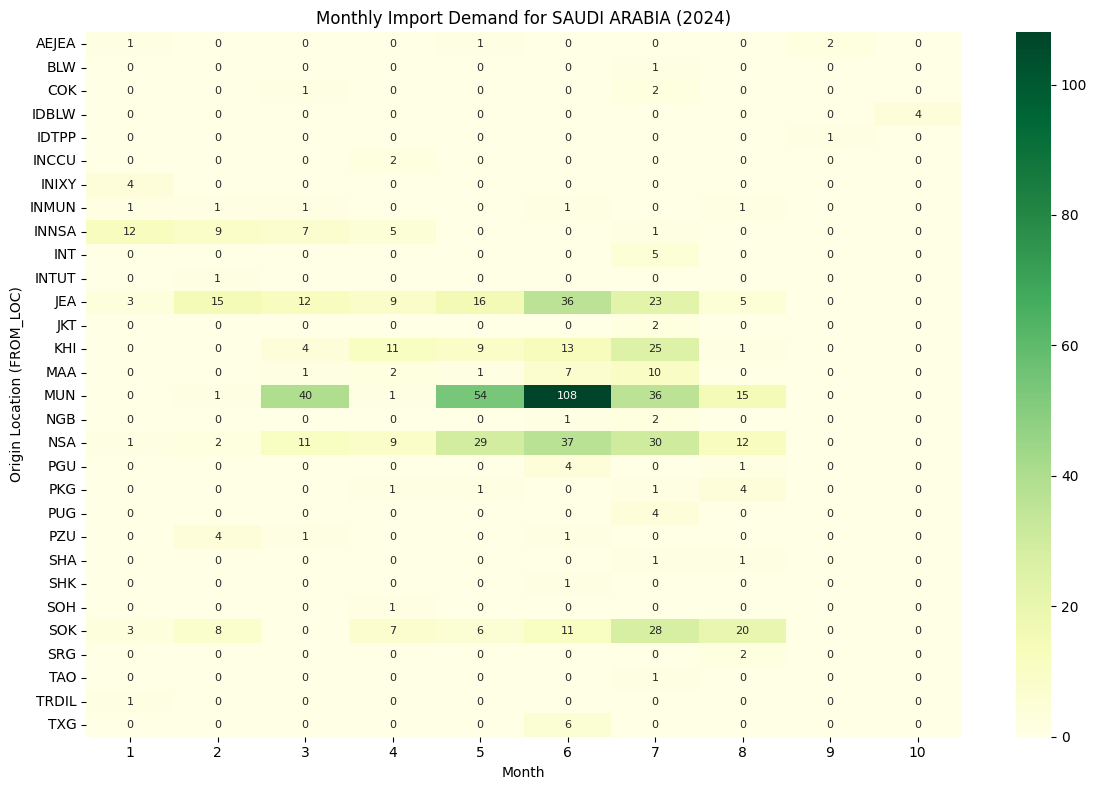

In [511]:
# Group by Month and FROM_LOC to count transactions (for discharge/imports)
monthly_location_demand = discharge.groupby(['PRIMARY_LOCATION', 'TRANSACTION_MONTH', 'FROM_LOC']).size().reset_index(name='TRANSACTION_COUNT')

# Create subplots for each location
unique_locations = monthly_location_demand['PRIMARY_LOCATION'].unique()
fig, axes = plt.subplots(len(unique_locations), 1, figsize=(12, 8 * len(unique_locations)))

# Ensure axes is always a list for easier iteration
if len(unique_locations) == 1:
    axes = [axes]

for idx, location in enumerate(unique_locations):
    # Filter data for current location
    location_data = monthly_location_demand[monthly_location_demand['PRIMARY_LOCATION'] == location]
    
    # Create pivot table for current location
    pivot_table = location_data.pivot_table(
        index='FROM_LOC', 
        columns='TRANSACTION_MONTH', 
        values='TRANSACTION_COUNT',
        fill_value=0
    )
    
    # Plot heatmap with smaller font size and no scientific notation
    sns.heatmap(
        pivot_table, 
        annot=True, 
        fmt='g',  # Use 'g' format to avoid scientific notation
        annot_kws={'size': 8},  # Decrease font size of annotations
        cmap='YlGn',  
        ax=axes[idx]
    )
    
    # Set title and labels
    axes[idx].set_title(f'Monthly Import Demand for {location} ({SELECTED_YEAR})')
    axes[idx].set_xlabel('Month')
    axes[idx].set_ylabel('Origin Location (FROM_LOC)')

plt.tight_layout()
plt.show()


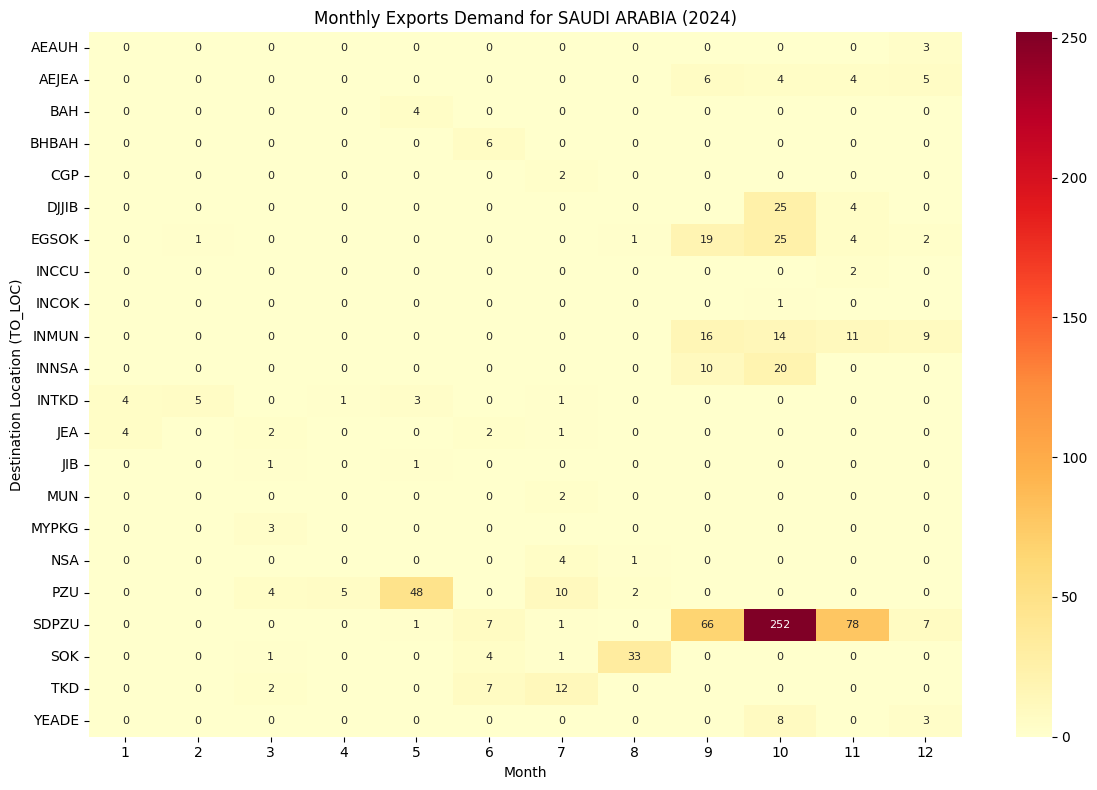

In [512]:
# Group by Month and TO_LOC to count transactions
monthly_location_demand = sailing.groupby(['PRIMARY_LOCATION', 'TRANSACTION_MONTH', 'TO_LOC']).size().reset_index(name='TRANSACTION_COUNT')

# Create subplots for each location
unique_locations = monthly_location_demand['PRIMARY_LOCATION'].unique()
fig, axes = plt.subplots(len(unique_locations), 1, figsize=(12, 8 * len(unique_locations)))

# Ensure axes is always a list for easier iteration
if len(unique_locations) == 1:
    axes = [axes]

for idx, location in enumerate(unique_locations):
    # Filter data for current location
    location_data = monthly_location_demand[monthly_location_demand['PRIMARY_LOCATION'] == location]
    
    # Create pivot table for current location
    pivot_table = location_data.pivot_table(
        index='TO_LOC', 
        columns='TRANSACTION_MONTH', 
        values='TRANSACTION_COUNT',
        fill_value=0
    )
    
    # Plot heatmap with smaller font size and no scientific notation
    sns.heatmap(
        pivot_table, 
        annot=True, 
        fmt='g',  # Use 'g' format to avoid scientific notation
        annot_kws={'size': 8},  # Decrease font size of annotations
        cmap='YlOrRd',  # Changed to a red-based colormap
        ax=axes[idx]
    )
    
    # Set title and labels
    axes[idx].set_title(f'Monthly Exports Demand for {location} ({SELECTED_YEAR})')
    axes[idx].set_xlabel('Month')
    axes[idx].set_ylabel('Destination Location (TO_LOC)')

plt.tight_layout()
plt.show()

# Statistical Inference
- Formulate one or two hypotheses based on the EDA findings.
- Use SciPy (or anything else you wish) to conduct appropriate staDsDcal analysis.
You could explore SciPy t-tests, chi-square tests, etc.
- Interpret the results of the staDsDcal tests to draw conclusions about the data.

## Formulate EDA's

In [513]:
chi2_stat, p_value = chisquare(
    f_obs=sailing.groupby(
            'TRANSACTION_MONTH'
        ).size().reindex(
            np.arange(1, 13), fill_value=0
    ).values,
    f_exp=np.array(
        [sailing.shape[0] / 12] * 12
    )
)
print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

Chi-square Statistic: 1564.4777070063694
P-value: 0.0


In [514]:
# Create a contingency table
contingency_table = pd.crosstab(discharge['FROM_LOC'], discharge['TO_LOC'])
chi2, p, dof, expected_table = chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
contingency_table

Chi-square Statistic: 369.3072443019829
P-value: 1.177844991425618e-60
Degrees of Freedom: 29


TO_LOC,SADMM,SAJED
FROM_LOC,,
AEJEA,3,1
BLW,0,1
COK,0,3
IDBLW,4,0
IDTPP,1,0
INCCU,2,0
INIXY,4,0
INMUN,3,2
INNSA,33,1


In [515]:
# Extract the numeric series for each group & Perform an independent t-test (if the variances are not assumed equal, set equal_var=False)
t_stat, p_val = ttest_ind(discharge['TRANSACTION_MONTH'], sailing['TRANSACTION_MONTH'], equal_var=False)
print("T-test Statistic:", t_stat)
print("P-value:", p_val)

T-test Statistic: -34.87875687848838
P-value: 3.163623122529545e-196


## Interpretations

In [516]:
# ?!?!?!

## Visualization and Presentation of Findings
- Create visualizaDons to present the findings from the EDA and staDsDcal tests.
- Use Matplotlib and Seaborn to generate clear, informaDve graphs. Or use
whatever visualizaDon library you wish.

In [517]:
# Make a copy of the relevant columns
data_comparision_df = df[['CLIENT_NAME', 'LOCATION_NAME', 'CONTAINER_NUMBER', 
                            'CONTAINER_SIZE', 'CONTAINER_TYPE', 
                            'DISCHARGE_DATE', 'SAILING_DATE']].copy()
# Convert date columns to datetime
data_comparision_df['DISCHARGE_DATE'] = pd.to_datetime(data_comparision_df['DISCHARGE_DATE'])
data_comparision_df['SAILING_DATE'] = pd.to_datetime(data_comparision_df['SAILING_DATE'])
# data_comparision_df = data_comparision_df[data_comparision_df['CONTAINER_SIZE'].isin([20, 40])]
data_comparision_df

,CLIENT_NAME,LOCATION_NAME,CONTAINER_NUMBER,CONTAINER_SIZE,CONTAINER_TYPE,DISCHARGE_DATE,SAILING_DATE
43,GMAC,SAUDI ARABIA,DAHU8106322,40,HC,2024-04-13,2025-02-11
68,GMAC,SAUDI ARABIA,OOLU8314638,40,HC,2024-03-13,2025-02-11
70,GMAC,SAUDI ARABIA,WCIU8291810,40,HC,2023-06-14,2025-02-11
72,GMAC,SAUDI ARABIA,FSCU9514479,40,HC,2023-07-29,2025-02-11
73,GMAC,SAUDI ARABIA,BAXU5006339,40,HC,2024-03-13,2025-02-11
...,...,...,...,...,...,...,...
8662,GMAC,SAUDI ARABIA,DAHU8107925,40,HC,2024-09-24,2024-11-02
8663,GMAC,SAUDI ARABIA,KCSU2211558,20,GP,2024-10-01,2024-12-17
8664,GMAC,SAUDI ARABIA,KCSU2181772,20,GP,2024-10-01,2024-11-11
8665,GMAC,SAUDI ARABIA,KCSU2171814,20,GP,2024-10-01,2024-11-04


In [518]:
# +1 for each discharge, -1 for each sailing.
discharge_events = data_comparision_df[['DISCHARGE_DATE', 'LOCATION_NAME', 'CONTAINER_SIZE']].copy()
discharge_events.rename(columns={'DISCHARGE_DATE': 'Date'}, inplace=True)
discharge_events['Count'] = 1
sailing_events = data_comparision_df[['SAILING_DATE', 'LOCATION_NAME', 'CONTAINER_SIZE']].copy()
sailing_events.rename(columns={'SAILING_DATE': 'Date'}, inplace=True)
sailing_events['Count'] = -1
# Combine the events
events = pd.concat([discharge_events, sailing_events], ignore_index=True)
events['Date'] = pd.to_datetime(events['Date'])
events

,Date,LOCATION_NAME,CONTAINER_SIZE,Count
0,2024-04-13,SAUDI ARABIA,40,1
1,2024-03-13,SAUDI ARABIA,40,1
2,2023-06-14,SAUDI ARABIA,40,1
3,2023-07-29,SAUDI ARABIA,40,1
4,2024-03-13,SAUDI ARABIA,40,1
...,...,...,...,...
1753,2024-11-02,SAUDI ARABIA,40,-1
1754,2024-12-17,SAUDI ARABIA,20,-1
1755,2024-11-11,SAUDI ARABIA,20,-1
1756,2024-11-04,SAUDI ARABIA,20,-1


In [519]:
# Group by location, container size, and date (in case there are multiple events on the same day)
grouped_events = events.groupby(['LOCATION_NAME', 'CONTAINER_SIZE', 'Date'])['Count'].sum().reset_index()
# Define the full date range for the selected year
start_date = pd.to_datetime(f'{SELECTED_YEAR}-01-01')
end_date   = pd.to_datetime(f'{SELECTED_YEAR}-12-31')
date_range = pd.date_range(start_date, end_date)
# For each combination of LOCATION_NAME and CONTAINER_SIZE, re-index to daily frequency and compute cumulative sum
cumulative_list = []
for (location, container_size), group in grouped_events.groupby(['LOCATION_NAME', 'CONTAINER_SIZE']):
    # Set the Date as the index and sort
    group = group.set_index('Date').sort_index()
    # Resample to daily frequency: if no event on a day, use 0.
    daily_counts = group['Count'].resample('D').sum().reindex(date_range, fill_value=0)
    # Compute the cumulative sum (i.e. running total)
    cumulative = daily_counts.cumsum().reset_index()
    cumulative.columns = ['Date', 'Cumulative_Count']
    # Add the group identifiers
    cumulative['LOCATION_NAME'] = location
    cumulative['CONTAINER_SIZE'] = container_size
    cumulative_list.append(cumulative)
# Combine all groups into one DataFrame
df_cumulative = pd.concat(cumulative_list, ignore_index=True)
df_cumulative

,Date,Cumulative_Count,LOCATION_NAME,CONTAINER_SIZE
0,2024-01-01,0,SAUDI ARABIA,20
1,2024-01-02,0,SAUDI ARABIA,20
2,2024-01-03,1,SAUDI ARABIA,20
3,2024-01-04,1,SAUDI ARABIA,20
4,2024-01-05,1,SAUDI ARABIA,20
...,...,...,...,...
727,2024-12-27,-12,SAUDI ARABIA,40
728,2024-12-28,-12,SAUDI ARABIA,40
729,2024-12-29,-12,SAUDI ARABIA,40
730,2024-12-30,-12,SAUDI ARABIA,40


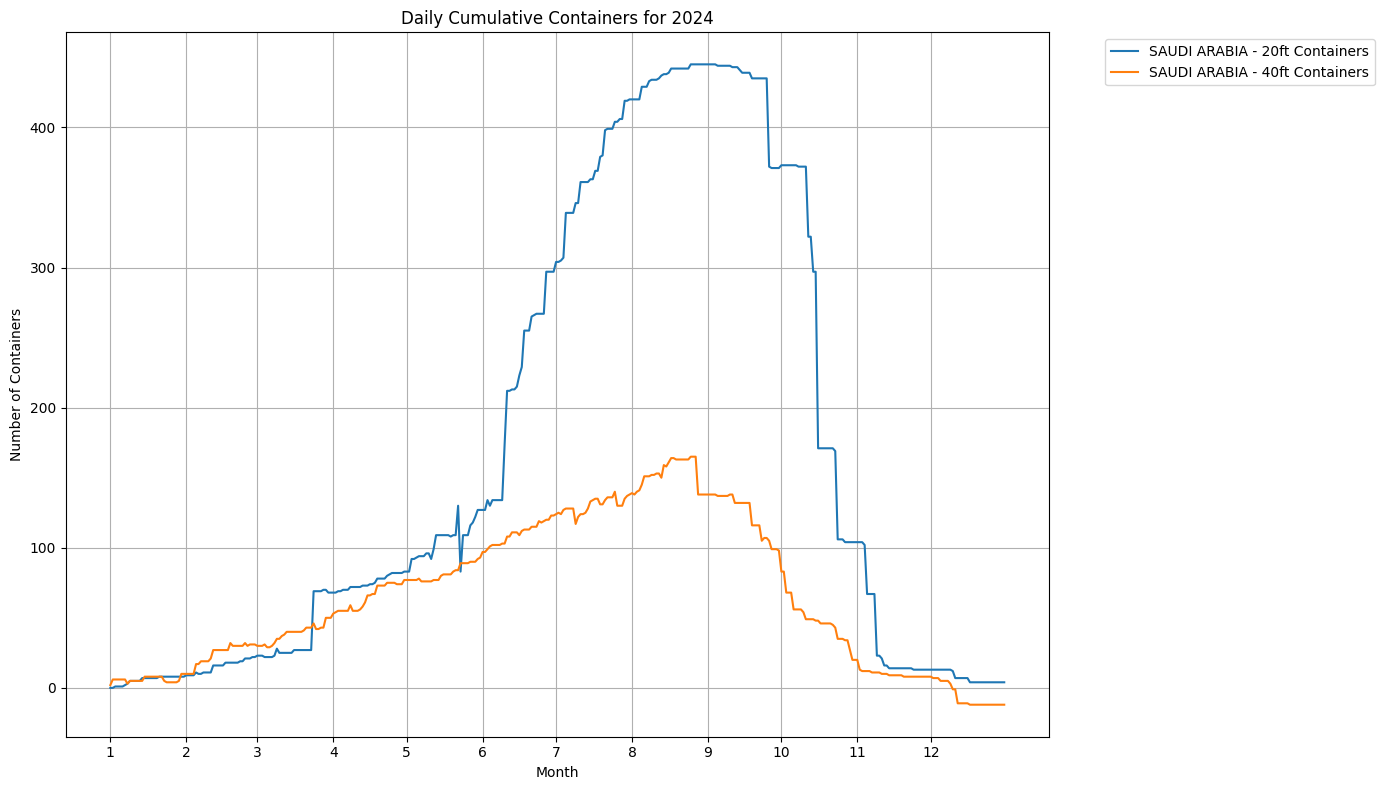

In [520]:
plt.figure(figsize=(14, 8))
# Loop through each unique location and container size, plotting each line on the same figure
for location in df_cumulative['LOCATION_NAME'].unique():
    for size in df_cumulative[df_cumulative['LOCATION_NAME'] == location]['CONTAINER_SIZE'].unique():
        subset = df_cumulative[(df_cumulative['LOCATION_NAME'] == location) &
                               (df_cumulative['CONTAINER_SIZE'] == size)]
        label = f"{location} - {size}ft Containers"
        plt.plot(subset['Date'], subset['Cumulative_Count'], label=label)
plt.xlabel("Month")
plt.ylabel("Number of Containers")
plt.title(f"Daily Cumulative Containers for {SELECTED_YEAR}")
# Create a date range for the first day of each month in the selected year
months = pd.date_range(start=f'{SELECTED_YEAR}-01-01', end=f'{SELECTED_YEAR}-12-31', freq='MS')
# Set the ticks to these dates and label them as 1, 2, 3, ..., 12
plt.xticks(months, range(1, 13))
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

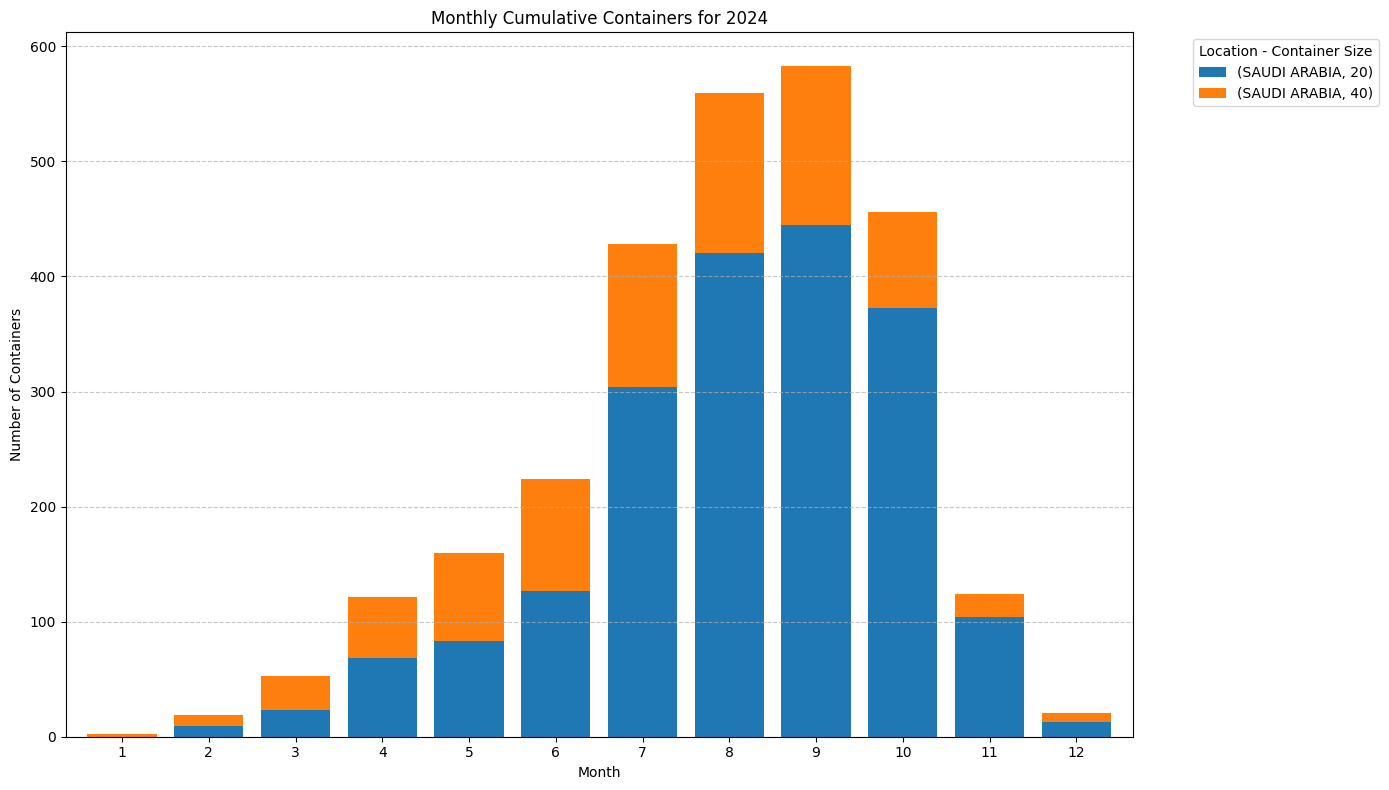

In [521]:
plt.figure(figsize=(14, 8))
# Create a pivot table to organize the data for the bar chart
df_pivot = df_cumulative.pivot_table(
    index='Date', columns=['LOCATION_NAME', 'CONTAINER_SIZE'], values='Cumulative_Count', aggfunc='sum'
)
# Ensure that only the first day of each month is considered
df_pivot = df_pivot[df_pivot.index.isin(pd.date_range(start=f'{SELECTED_YEAR}-01-01', end=f'{SELECTED_YEAR}-12-31', freq='MS'))]
# Plot a stacked bar chart for each month
df_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8)
plt.xlabel("Month")
plt.ylabel("Number of Containers")
plt.title(f"Monthly Cumulative Containers for {SELECTED_YEAR}")
# Set the x-ticks to 1, 2, ..., 12 representing months
plt.xticks(range(12), range(1, 13), rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Location - Container Size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
